# Identify the most influential Congress members

In this tutorial, we will apply PySpark and **GraphFrames** to analyze the 117th U.S. congressional Twitter network and identify the most influential members. The key steps include:

1.  **Setup**: Initialize a PySpark session configured for GraphFrames.
2.  **Graph creation**: Construct a graph (nodes and edges) from sample data.
3.  **Exploratory Data Analysis**: Calculate basic network metrics (e.g., node degrees) to gain an initial understanding of the data.
4.  **PageRank Analysis**: Run the PageRank algorithm to rank the nodes.
5.  **Result Visualization**: Visualize the most influential members.

**Credits**

Dataset cited from C.G. Fink, K. Fullin, G. Gutierrez, N. Omodt, S. Zinnecker, G. Sprint, and S. McCulloch: *A centrality measure for quantifying spread on weighted, directed networks.* Physica A, 2023. <https://snap.stanford.edu/data/congress-twitter.html>

**Compatibility**

| Platform | Compatibility | Recommended | Notes |
| :--- | :--- | :--- | :--- |
| **Local Machine** (e.g., 16GB RAM Laptop) | ✅ Yes | ✅ Yes | Suitable for this dataset size and for local development. |
| **Google Colab** | ✅ Yes | ✅ Yes | A viable option for executing the notebook, the dataset fits within standard Colab instance memory. |
| **Midway3 Login Node** | ✅ Yes | ❌ No | **Not Recommended.** Login nodes are shared resources; running intensive computations can disrupt other users. |
| **Midway3 Compute Node** | ✅ Yes | ✅ Yes | **Recommended.** Ideal for this workload, allowing for efficient and scalable computation without impacting shared resources. |

-----

## Data

This tutorial uses the dataset of **Twitter Interaction Network for the 117th U.S. Congress**, sourced from the [Stanford Network Analysis Project (SNAP)](https://snap.stanford.edu/data/congress-twitter.html). The data captures interactions in 3,200 tweets over a four-month period, from **February 9, 2022, to June 9, 2022**.

* **Network Type**: It is a **directed** graph. An edge from Member A to Member B means Member B interacted with a tweet from Member A, indicating a one-way flow of influence.
* **Nodes (Vertices)**: The nodes are the **475** members of the 117th Congress who were sufficiently active on Twitter during the collection window (defined as having at least 100 tweets).
* **Edges (Links)**: The **13,289** edges represent Twitter interactions, specifically **retweets**, **quote tweets**, **replies**, and **mentions**.
* **Edge Weights (Transmission Probability)**: Each edge from a member $i$ to a member $j$ is assigned a weight that represents the **empirical probability of influence**. This value is calculated by taking the total number of times member $j$ interacted with member $i$'s tweets and dividing it by the total number of tweets published by member $i$.

    
    $$P(i \rightarrow j) = \frac{\text{Total times } j \text{ interacted with } i}{\text{Total tweets by } i}$$

    This weight quantifies the likelihood that any single tweet from member $i$ would provoke a public interaction from member $j$.

### Files

The analysis relies on two key data files:

* **`congress.edgelist`**: This text file defines the network's connections (the "edges"). Each line represents a single, directed link from one member to another and follows a space-separated format:
    * `source_id`: The integer ID of the member initiating the interaction (e.g., `0`).
    * `destination_id`: The integer ID of the member receiving the interaction (e.g., `4`).
    * `{'weight': value}`: A dictionary-like string containing a floating-point `weight` that quantifies the strength of the interaction. A higher weight implies a stronger connection.

* **`congress_network_data.json`**: This JSON file contains the metadata for the network's nodes (the "vertices"), such as `inList`, `outList`, `inWeight` and `outWeight`, the important field for this tutorial is:
    * `usernameList`: A list of Twitter usernames. The position (or index) of a username in this list directly corresponds to its integer `id` used in the `congress.edgelist` file. For example, the username at index `0` of this list is `SenatorBaldwin`, the member represented by `id` 0.


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, monotonically_increasing_id, regexp_extract

## 1. Setup: Initialize a Spark Session

Now, we will start a Spark session. Because **GraphFrames** is an external package, we need to explicitly instruct Spark to download and include it -- this is an essential first step.

In [ ]:
# This environment variable tells Spark to fetch the GraphFrames package.
# The version must be compatible with your Spark and Scala versions.
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.8.4-spark3.5-s_2.12 pyspark-shell'

# Initialize our Spark Session
spark = (
    SparkSession.builder
    .appName("CongressionalTwitterAnalysis")
    .getOrCreate()
)

# IMPORTANT: Import GraphFrame *after* the session is configured and started.
from graphframes import GraphFrame

print("✅ Spark session and GraphFrames successfully initialized!")

✅ Spark session and GraphFrames successfully initialized!


## 2. Construct a graph from the social network data

A graph includes two key components:

  * **Nodes (or Vertices)**: these represent the individual entities in the network - in this task, they are the congress members.
  * **Edges (or Links)**: These represent the connections between nodes. In this task, an edge represents a Twitter interaction (such as retweet or mention). The edges here are **directed** (A -\> B is different from B -\> A) and **weighted**.

In [ ]:
# If you are using Midway, run this code
# DATA_DIR = "../datasets/congress-network"

In [ ]:
# If you are using Google Colab, run this code
!mkdir -p "./datasets"
!wget -P "./datasets" -q https://snap.stanford.edu/data/congress_network.zip
!cd "./datasets" && unzip congress_network.zip && mv congress_network congress-network

DATA_DIR = "./datasets/congress-network"

Archive:  congress_network.zip
  inflating: congress_network/compute_vc.py  
  inflating: congress_network/congress.edgelist  
  inflating: congress_network/congress_network_data.json  
  inflating: congress_network/histogram_weights.py  
  inflating: congress_network/README.txt  
  inflating: congress_network/viral_centrality.py  


In [ ]:
# --- Load the network connection files (congress.edgelist) ---
# Each line represents a directed edge: source_id, destination_id, weight
file_path = os.path.join(DATA_DIR, "congress.edgelist")
text_df = spark.read.text(file_path)

# Define the regular expression extract the three components
regex_pattern = r"(\d+)\s+(\d+)\s+\{'weight':\s*([\d\.]+)\}"

# Apply the regex to extract the data and cast the data type
edges_df = text_df.select(
    regexp_extract(col("value"), regex_pattern, 1).cast("long").alias("src"),
    regexp_extract(col("value"), regex_pattern, 2).cast("long").alias("dst"),
    regexp_extract(col("value"), regex_pattern, 3).cast("double").alias("weight")
)

# --- Load the member usernames file ---
with open(os.path.join(DATA_DIR, "congress_network_data.json"), 'r') as f:
    json_data = json.load(f)

# Load usernames into a DataFrame
usernames = json_data[0]['usernameList']
usernames_df = spark.createDataFrame(pd.DataFrame({'username': usernames}))

# Create a unique 'id' column for each user.
# monotonically_increasing_id() generates unique IDs that align with our edgelist indices (0, 1, 2...).
# The ID type must be long to match GraphFrames requirements.
vertices_df = usernames_df.withColumn("id", monotonically_increasing_id())

print("--- Edges (Interactions) DataFrame ---")
edges_df.show()

print("--- Vertices (Members) DataFrame ---")
vertices_df.show()

--- Edges (Interactions) DataFrame ---
+---+---+--------------------+
|src|dst|              weight|
+---+---+--------------------+
|  0|  4|0.002105263157894737|
|  0| 12|0.002105263157894737|
|  0| 18|0.002105263157894737|
|  0| 25|0.004210526315789474|
|  0| 30|0.002105263157894737|
|  0| 46| 0.00631578947368421|
|  0| 55|0.002105263157894737|
|  0| 58|0.002105263157894737|
|  0| 59|0.004210526315789474|
|  0| 74|0.002105263157894737|
|  0| 76|0.004210526315789474|
|  0| 77|0.002105263157894737|
|  0| 85|0.002105263157894737|
|  0| 86|0.002105263157894737|
|  0| 87| 0.00631578947368421|
|  0|154|0.002105263157894737|
|  0|168| 0.00631578947368421|
|  0|341|0.010526315789473684|
|  0|374| 0.01263157894736842|
|  0|401|0.002105263157894737|
+---+---+--------------------+
only showing top 20 rows

--- Vertices (Members) DataFrame ---
+---------------+---+
|       username| id|
+---------------+---+
| SenatorBaldwin|  0|
|SenJohnBarrasso|  1|
|  SenatorBennet|  2|
|MarshaBlackburn|  3|


## 3. Exploratory Data Analysis: understanding the Graph Structure

Let's first explore the graph's basic properties.

  * **In-Degree**: The number of incoming edges to a node. In this task, it represents the **popularity or visibility** of a member — how many other members mention, reply to, or retweet them.
  * **Out-Degree**: The number of outgoing edges from a node. This represents a member's **activity** — how many other members they are actively interacting with.


In [ ]:
# Create a GraphFrame object using the nodes and edges
# The 'id' column in vertices_df must match the 'src' and 'dst' columns in edges_df.
g = GraphFrame(vertices_df, edges_df)

print(f"Total Members (Vertices): {g.vertices.count()}")
print(f"Total Connections (Edges): {g.edges.count()}")

# --- In-Degrees: Who gets the most attention? ---
in_degrees = g.inDegrees
top_in_degrees = (
    in_degrees.join(vertices_df, "id")
    .orderBy(desc("inDegree"))
)
print("\n--- Top 5 Members by Incoming Edges (In-Degree) ---")
top_in_degrees.show(5)

# --- Out-Degrees: Who is most active? ---
out_degrees = g.outDegrees
top_out_degrees = (
    out_degrees.join(vertices_df, "id")
    .orderBy(desc("outDegree"))
)
print("\n--- Top 5 Members by Outgoing Edges (Out-Degree) ---")
top_out_degrees.show(5)


Total Members (Vertices): 475
Total Connections (Edges): 13289

--- Top 5 Members by Incoming Connections (In-Degree) ---
+---+--------+-------------+
| id|inDegree|     username|
+---+--------+-------------+
|208|     121|  RepFranklin|
|190|     120|RepJeffDuncan|
|111|     109|  RepDonBeyer|
|192|     105|  RepTomEmmer|
|147|      97|    RepCasten|
+---+--------+-------------+
only showing top 5 rows


--- Top 5 Members by Outgoing Connections (Out-Degree) ---
+---+---------+--------------+
| id|outDegree|      username|
+---+---------+--------------+
| 71|       97|    SenSchumer|
|179|       84|   rosadelauro|
|105|       75|   RepJimBanks|
| 87|       71|     SenWarren|
|113|       65|RepAndyBiggsAZ|
+---+---------+--------------+
only showing top 5 rows



In [ ]:
# --- Strongest Individual Connections ---
# alias vertices for source and destination
src_v = vertices_df.alias("src_v")
dst_v = vertices_df.alias("dst_v")

strongest_connections = (
    g.edges
     # join to get source username
     .join(src_v, col("src") == col("src_v.id"))
     # join to get dest username
     .join(dst_v, col("dst") == col("dst_v.id"))
     .select(
         col("src_v.username").alias("source_user"),
         col("dst_v.username").alias("dest_user"),
         col("weight")
     )
     .orderBy(desc("weight"))
)

print("\n--- Top 5 Strongest Connections by Weight ---")
strongest_connections.show(5, truncate=False)


--- Top 5 Strongest Connections by Weight ---
+--------------+--------------+-------------------+
|source_user   |dest_user     |weight             |
+--------------+--------------+-------------------+
|RonWyden      |SenJeffMerkley|0.13056379821958458|
|SenGillibrand |SenLummis     |0.11538461538461539|
|SenHydeSmith  |SenatorWicker |0.09504132231404959|
|RepBost       |RodneyDavis   |0.09090909090909091|
|SenCortezMasto|SenJackyRosen |0.07746478873239436|
+--------------+--------------+-------------------+
only showing top 5 rows



The strongest connection, with a weight of approximately `0.064`, occurs from **Senator Tom Cotton** to **Senator John Boozman**. This indicates that during the four-month observation period, Senator Boozman publicly interacted with about 6.4% of Senator Cotton's tweets (retweeted, replied to, quoted, or mentioned). It means that tweets from Senator Cotton had a relatively high chance of being amplified by his colleague.

A clear real-world political pattern emerges from these results. The strongest connections are often between senators from the **same state**, such as Tom Cotton and John Boozman (Arkansas), Chuck Grassley and Joni Ernst (Iowa), and the reciprocal relationship between John Hickenlooper and Michael Bennet (Colorado). This reflects their shared constituency and the political incentive to collaborate and amplify each other's messages on issues relevant to their home state. Other strong links, such as from Senator Hagerty (TN) to Senator Cornyn (TX), shows strong ideological or partisan alliances, where members actively reinforce one another's messaging to reach a broader audience.

**Visualizing Node Degrees**

Let's then visualize the top members by in-degree and out-degree.

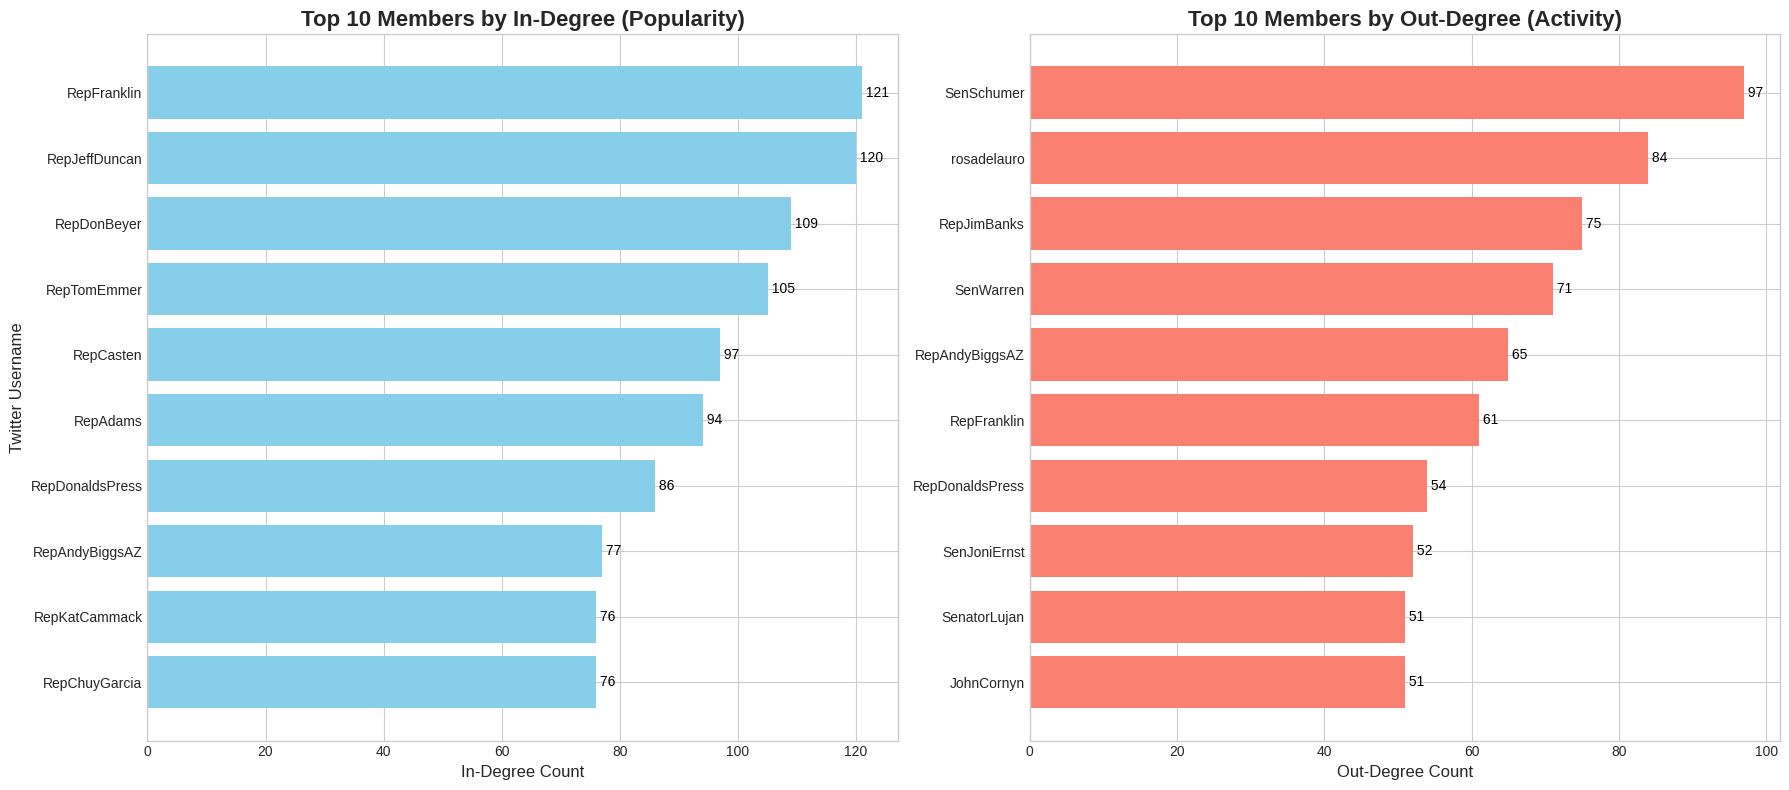

In [ ]:
# Collect data for plotting
top_10_indegree_pd = top_in_degrees.limit(10).toPandas()
top_10_outdegree_pd = top_out_degrees.limit(10).toPandas()

# Create the plots using Matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot In-Degree
ax1.barh(top_10_indegree_pd['username'], top_10_indegree_pd['inDegree'], color='skyblue')
ax1.invert_yaxis()
ax1.set_xlabel('In-Degree Count', fontsize=12)
ax1.set_ylabel('Twitter Username', fontsize=12)
ax1.set_title('Top 10 Members by In-Degree (Popularity)', fontsize=16, fontweight='bold')
for i, v in enumerate(top_10_indegree_pd['inDegree']):
    ax1.text(v, i, f" {v}", color='black', va='center')

# Plot Out-Degree
ax2.barh(top_10_outdegree_pd['username'], top_10_outdegree_pd['outDegree'], color='salmon')
ax2.invert_yaxis()
ax2.set_xlabel('Out-Degree Count', fontsize=12)
ax2.set_title('Top 10 Members by Out-Degree (Activity)', fontsize=16, fontweight='bold')
for i, v in enumerate(top_10_outdegree_pd['outDegree']):
    ax2.text(v, i, f" {v}", color='black', va='center')


plt.tight_layout()
plt.show()

The in-degree and out-degree visualizations highlights two dimensions of members' Twitter behavior: **popularity** (how often they receive interactions) and **activity** (how often they initiate interactions).

* The **"In-Degree (Popularity)"** chart on the left shows which members were most frequently mentioned, replied to, or retweeted by their colleagues. **Senator John Cornyn** is stands out prominently, positioning him a central figure and a primary focuse of attention within the network.

* The **"Out-Degree (Activity)"** chart on the right shows which members were most active in mentioning, replying to, or retweeting others. **Senator Joni Ernst** ranks as the most active participant, suggesting she engages with the broadest range of colleagues.

Notably, members such as **John Cornyn**, **Dick Durbin**, and **Amy Klobuchar** appear on both lists, indicating that they are key communicators who not only drive the conversations but also serve as central figures within the network. This suggests they are highly connected and influential nodes within the Congressional Twitter network.

## 4. Rank nodes with the PageRank Algorithm

PageRank is an algorithm that assigns a numerical "influence" score to each node in a network. The core idea is that a node is important if it receives links from other important nodes. In this Twitter network, a Congress Member is considered influential if they are frequently retweeted, mentioned, or replied to by other influential members. The influence score, $PR(u)$, for a user $u$ is generally defined as:

$$PR(u) = \frac{1-d}{N} + d \sum_{v \in B_u} \frac{PR(v)}{L(v)}$$

- $N$ is the total number of nodes in the network
- $d$ is a damping factor
- $B_u$ is the set of nodes that link to $u$
- $L(v)$ is the number of outgoing links from node $v$.

In the following analysis, we will use a **weighted** version of **PageRank** (e.g., interactions with higher `weight` pass more influence) to calculate an influence score for each member.

In [ ]:
# Run the weighted PageRank algorithm
# resetProbability: The "damping factor." Probability of a random jump. Standard value is 0.15.
# maxIter: The number of iterations to run. More iterations lead to more stable scores.
# weightCol: This is the key! We tell PageRank to use our 'weight' column.
pagerank_results = g.pageRank(resetProbability=0.15, maxIter=20)

# Join the PageRank scores back to the usernames for a clear, final result.
top_pagerank = (
    pagerank_results.vertices
    .select("id", "username", "pagerank")
    .orderBy(desc("pagerank"))
)

print("--- Top 10 Most Influential Members by PageRank ---")
top_pagerank.show(10, truncate=False)

--- Top 10 Most Influential Members by PageRank ---
+---+---------------+------------------+
|id |username       |pagerank          |
+---+---------------+------------------+
|208|RepFranklin    |6.128204712926516 |
|190|RepJeffDuncan  |5.869311608788171 |
|192|RepTomEmmer    |5.575417528155262 |
|147|RepCasten      |4.974872940434539 |
|111|RepDonBeyer    |4.706355851106165 |
|92 |RepAdams       |4.3692276088002595|
|188|RepDonaldsPress|4.342857395212215 |
|113|RepAndyBiggsAZ |4.090035092469856 |
|137|RepKatCammack  |3.904838972567249 |
|215|RepChuyGarcia  |3.563256228933122 |
+---+---------------+------------------+
only showing top 10 rows



## 5. Visualize the Influence 📊

In this section, we'll create a bar chart to visualize the top-ranked members by PageRank score. We will first collect the results from our distributed Spark DataFrame into a local Pandas DataFrame.

⚠️ **Note**: Only use `.toPandas()` on smaller, aggregated DataFrames. Attempting to pull a massive DataFrame into memory will cause errors.

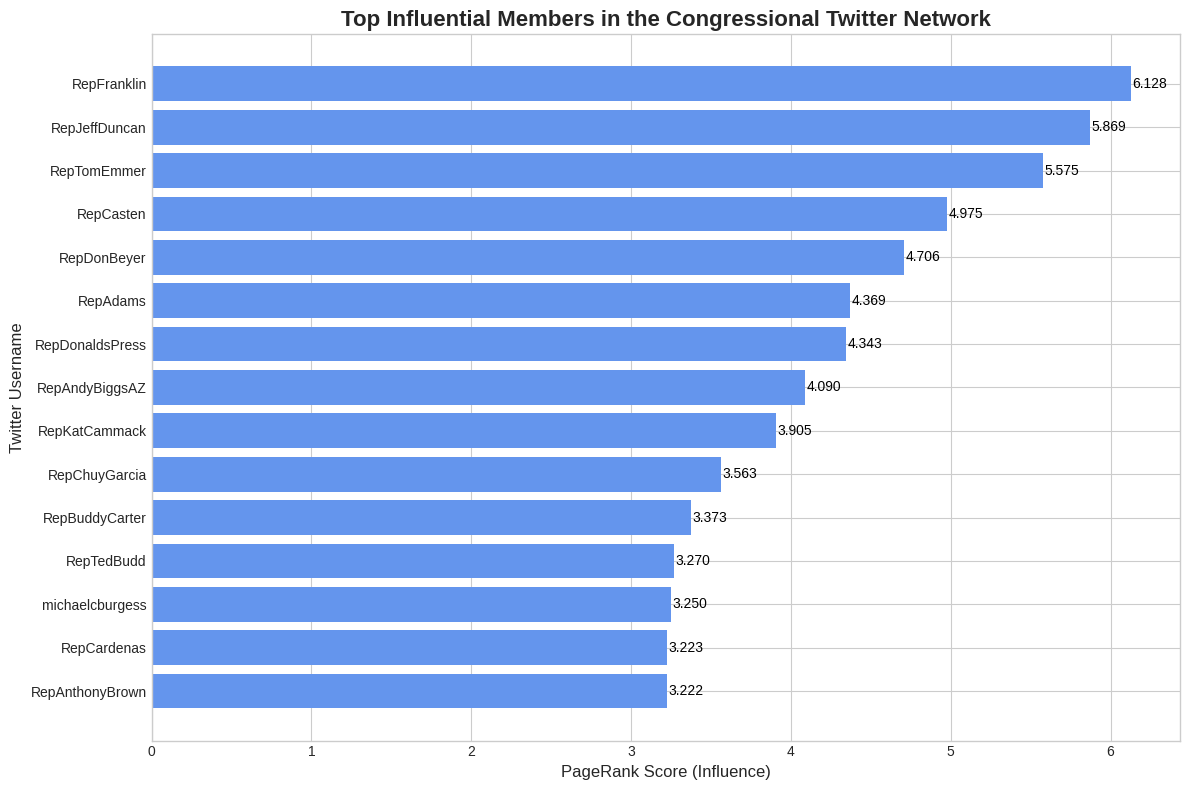

In [ ]:
# Collect the top 15 results into a Pandas DataFrame for plotting
top_15_pandas = top_pagerank.limit(15).toPandas()

# Create the plot using Matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bars
ax.barh(top_15_pandas['username'], top_15_pandas['pagerank'], color='cornflowerblue')

# Invert y-axis to show the highest rank at the top
ax.invert_yaxis()

# Set labels and title for clarity
ax.set_xlabel('PageRank Score (Influence)', fontsize=12)
ax.set_ylabel('Twitter Username', fontsize=12)
ax.set_title('Top Influential Members in the Congressional Twitter Network', fontsize=16, fontweight='bold')

# Add the score value as a label on each bar
for i, v in enumerate(top_15_pandas['pagerank']):
    ax.text(v + 0.01, i, f"{v:.3f}", color='black', va='center')

plt.tight_layout()
plt.show()

This chart displays the final PageRank scores. Unlike simple popularity measurements by in-degree, PageRank assigns greater importance to interactions coming from other influential members. A high score indicates that an individual isn't just frequently mentioned, but is recognized and engaged by other important members, making them a central hub of information and influence.

The members at the top of this list are predominantly senior figures with substantial institutional authority, which explains their high influence scores:

* **John Cornyn (R-TX):** A a long-serving and influential senator on key committees such as Finance and Judiciary, Senator Cornyn plays a central role in shaping Republican policy and strategy. His top ranking underscores his position as a critical member in public-facing political communications.

* **Ben Cardin (D-MD) & Amy Klobuchar (D-MN):** Both are senior Democrats who chaired influential committees during the 117th Congress (Cardin leading the Small Busines Committee and Klobuchar leading the powerful Rules Committee). Their high rankings indicate that their online interactions holds significant influence among their colleagues.

* **Dick Durbin (D-IL):** Serving as the Senate Majority Whip, Senator Durbin was the #2 Democrat in the Senate. His official role required him to act as a central communicator for the party. His high PageRank score directly mirrors this real-world leadership position.

In summary, the PageRank algorithm successfully identifies members whose online influence aligns closely with their real-world political power and leadership roles within their respective parties.

## Conclusion & Next Steps

In this tutorial, we demonstrated a full graph analysis workflow using PySpark. We structured the raw data files into a `GraphFrame`, conducted exploratory data analysis with visualizations, and applied the **weighted PageRank** algorithm. The final visualization clearly reveals the most central and influential figures within the sample network.

This process demonstrates how PySpark and GraphFrames can be leveraged to analyze large-scale networks and uncover insights that would be difficult to find using traditional data analysis methods. From this foundation, the analysis could be expanded in several promising directions:

* **Integrate Ideological Data:** You could combine the PageRank results with external political science datasets such as **DW-NOMINATE scores**. Comparing a member's influence score with their ideological position would allow you to explore whether influence is concentrated among party leaders, ideological hardliners, or more moderate 'swing' members.

* **Compare Weighted and Unweighted Results:** In this analysis, we used a *weighted* PageRank that accounts for the strength of relationships. A useful next step would be to run a standard, *unweighted* PageRank and compare the outcomes. This comparison would show how influence rankings shift when all connections are treated equally, emphasizing the role of interaction probabilities in shaping network dynamics.

* **Detect Communities:** You could explore other graph algorithms for community detection, which we will explpre in later weeks! This could help empirically identify **partisan or bipartisan, or even non-partisan clusters** based solely on patterns of interaction within the network.